In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [2]:
%cd '/content/drive/My Drive/image_classification/'

/content/drive/My Drive/image_classification


In [3]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

%matplotlib inline

In [4]:
IMG_DIM = (150, 150)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[1].split()[0].strip() for fn in train_files]

validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[1].split()[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (400, 150, 150, 3) 	Validation dataset shape: (50, 150, 150, 3)


In [5]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

(150, 150, 3)


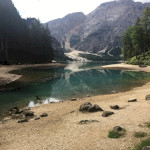

In [6]:
# visualize a sample image
print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [7]:
batch_size = 120
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
# encode wine type labels
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[195:205], train_labels_enc[195:205])

['landslide', 'landslide', 'landslide', 'landslide', 'landslide', 'others', 'others', 'others', 'others', 'others'] [0 0 0 0 0 1 1 1 1 1]


In [8]:
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)

vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

for layer in vgg_model.layers:
    layer.trainable = False

vgg_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [9]:
import pandas as pd
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f5fc8a9b0d0>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5fc8ab2f50>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5fcffb1190>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f5fc81f3790>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5fc81f9090>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5fc81fd810>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f5fc8208910>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5fc007a150>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5fc8201490>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5fc00829d0>,block3_conv3,False


In [10]:
print("Trainable layers:", vgg_model.trainable_weights)

Trainable layers: []


In [11]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
print("Trainable layers:", vgg_model.trainable_weights)

Trainable layers: [<tf.Variable 'block4_conv1/kernel:0' shape=(3, 3, 256, 512) dtype=float32, numpy=
array([[[[-1.24538150e-02,  8.40655994e-03, -5.28845051e-03, ...,
          -2.04581907e-03, -3.92359449e-03,  1.30683812e-03],
         [ 1.15566896e-02,  2.46055960e-03, -4.09082584e-02, ...,
          -4.92062652e-03, -1.63423386e-03,  8.94230697e-03],
         [-1.43469922e-04, -5.65873180e-03,  1.84066985e-02, ...,
          -2.08840682e-03,  2.63321817e-06, -2.50728261e-02],
         ...,
         [ 1.37888230e-02, -6.58180192e-03,  9.65370331e-03, ...,
           7.17610447e-03,  3.45725450e-03,  5.33173978e-03],
         [ 2.65833316e-03,  7.77704641e-04,  2.86239345e-04, ...,
          -5.40583069e-03,  8.93119723e-03,  1.40043022e-02],
         [-8.53933115e-03,  1.43394794e-03, -2.91879033e-03, ...,
           3.77660524e-03,  2.05454584e-02, -1.35868033e-02]],

        [[-1.20176468e-02,  1.51250837e-03,  3.43130133e-03, ...,
          -1.57830697e-02, -2.39501009e-03,  2.93

In [12]:
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f5fc8a9b0d0>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5fc8ab2f50>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5fcffb1190>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f5fc81f3790>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5fc81f9090>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5fc81fd810>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f5fc8208910>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5fc007a150>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5fc8201490>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f5fc00829d0>,block3_conv3,False


In [13]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [14]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 8192)              14714688  
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 19,172,673
Trainable params: 17,437,185
Non-trainable params: 1,735,488
____________________________________

In [15]:
history = model.fit_generator(train_generator, 
                                  steps_per_epoch=int(np.ceil(400 / float(batch_size))), 
                                  epochs=100,
                                  validation_data=val_generator, 
                                  validation_steps=int(np.ceil(50 / float(batch_size))), 
                                  verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
4/4 [==============================] - 35s 640ms/step - loss: 0.7498 - accuracy: 0.5122 - val_loss: 0.6062 - val_accuracy: 0.8000
Epoch 2/100
4/4 [==============================] - 1s 184ms/step - loss: 0.6033 - accuracy: 0.6267 - val_loss: 0.6527 - val_accuracy: 0.6000
Epoch 3/100
4/4 [==============================] - 1s 183ms/step - loss: 0.5741 - accuracy: 0.7200 - val_loss: 0.5535 - val_accuracy: 0.8000
Epoch 4/100
4/4 [==============================] - 1s 180ms/step - loss: 0.5980 - accuracy: 0.7200 - val_loss: 0.5258 - val_accuracy: 0.8000
Epoch 5/100
4/4 [==============================] - 1s 189ms/step - loss: 0.4616 - accuracy: 0.8044 - val_loss: 0.4456 - val_accuracy: 0.9000
Epoch 6/100
4/4 [==============================] - 1s 354ms/step - loss: 0.4508 - accuracy: 0.7876 - val_loss: 0.4272 - val_accuracy: 0.8500
Epoch 7/100
4/4 [==============================] - 1s 187ms/step - loss: 0.4238 - accuracy: 0.8533 - val_loss: 0.3481 - val_accuracy: 0.9500
Epoch 8/100


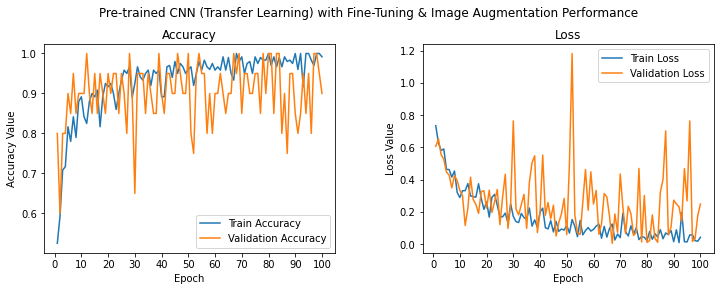

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Fine-Tuning & Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [17]:
model.save('landslide_others_tlearn_finetune_img_aug_cnn.h5')